In [1]:
%matplotlib inline
import netCDF4
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2002-12-31 00:00:00
1095


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF2DFM/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)

/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR


## create CMF model BMI object

In [6]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
print(CMF_engine)
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date, dt=86400)


/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/cama-flood_bmi/src/libcama.so


## create DFM model BMI object

In [7]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date, dt=86400.)

/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/DFM


## intitialize DFM model

In [8]:
# initialize DFM first to expose model coordinates via BMI
DFM_bmi.initialize()

## couple grids based on CMF inpmat file

In [9]:
# couple grids
PCR_bmi.couple_grid_to_grid(CMF_bmi)

## couple CMF to DFM based on 1d DFM indices

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

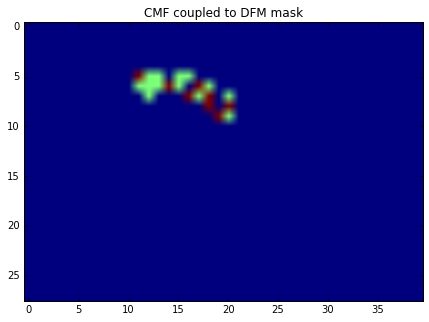

In [10]:
# get coupled dictionaries
CMF_bmi.couple_grid_to_1d(DFM_bmi)

fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(CMF_bmi.coupled_mask, vmin=0, vmax=2)
b.set_title('CMF coupled to DFM mask')

note there is a difference in DFM nodes and DFM coupled nodes as some are in unit catchments that are ignored by CMF. The runoff from PCR is however mass-conservative in the CMF runoff input.

In [11]:
len(DFM_bmi.model_1d_coords), len(DFM_bmi.coupled_idx)

(1428, 1425)

## initialize CMF and PCR models

In [12]:
# initialize CMF model after nextxy had been adapted
CMF_bmi.initialize()
# initialize model after ldd has been modified
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-03-09 11:56:30.198349
2018-03-09 11:56:30,209 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-09 11:56:30.198349
INFO: configuration.initialize_logging(): Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-09T11:56:30.198349.log
2018-03-09 11:56:30,211 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-09T11:56:30.198349.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-03-09 11:56:30,213 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used in this

## define exchange of values in update states function

In [13]:
def get_CMF_delta_vol():
    # coupled 2d mask
    mask = (CMF_bmi.coupled_mask > 0).astype(float)
    # total Q inflow 2D for coupled cells
    q_in = (CMF_bmi.get_var('rivinf') + CMF_bmi.get_var('fldinf')) * mask # [m3/s]
    # total CMF converted runoff inflow 2D for coupled cells
    runoff = CMF_bmi.get_var('runoff') * mask # [m3/s]
    # take Qin + runoff in most upstream coupled cells, only runoff for other cells
    tot_flux = np.where(CMF_bmi.coupled_mask == 2, q_in + runoff, runoff)
    # convert flux to volume per day
    delta_vol = tot_flux * CMF_bmi.options['dt'] # [m3/day]
    return delta_vol 

def set_CMF_forcing():
    "coupling runoff between CMFan PCR model"
    runoff = PCR_bmi.get_var('landSurfaceRunoff') # [m/day]
    runoff = np.where(np.isnan(runoff), 0, runoff)
    # note that runoff in (roffin) should be used to set PCR runoff. 
    CMF_bmi.set_var("roffin", runoff) # [m/dtin] = [m/d]

DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
CMFidx = CMF_bmi.coupled_idx
CMFfrac = CMF_bmi.coupled_area_frac

def set_DFM_forcing():
    CMF_delta_vol = get_CMF_delta_vol() # 2d array [m3/day]
    DFM_depth_conservative = CMF_delta_vol[CMFidx] * CMFfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)
        

## find location to record qsim from CMF on the fly

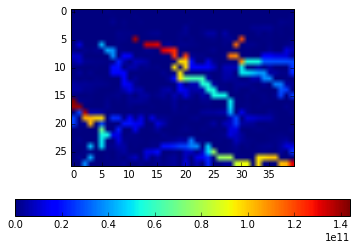

In [14]:
#- get upsteram area at comparison point in CMF
upArea = np.fromfile(r'/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/CMF_Elbe/uparea.bin', 'f').reshape(28,40)
plt.imshow(upArea)
plt.colorbar(orientation='horizontal')

In [15]:
#- check whether upstream area at chosen location is at the upper end
#- upstream area according to GRDC: 131950 km2 = 1.31950e11 m2
xCMFout = 6
yCMFout = 13
print (upArea[xCMFout, yCMFout])

1.34112e+11


## run coupled CMF - DFM model

In [16]:
# create file for writing CMF output
cmf_outFile = os.path.join(CMF_out_dir, 'qsim_CFM_at_location_' + str(xCMFout) + '_' + str(yCMFout) + '.txt')
cmf_of = open(cmf_outFile, 'w')
print (cmf_of)

<open file u'/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/CMF/qsim_CFM_at_location_6_13.txt', mode 'w' at 0x7ffa2dd4db70>


In [17]:
# run for numer of timesteps specified in set-file
tStart = datetime.now()
for i in range(timeSteps):
# for i in range(5):
    PCR_bmi.update()
    set_CMF_forcing()
    CMF_bmi.update()
    outflw_temp = np.copy(CMF_bmi.get_var('outflw'))[xCMFout, yCMFout]
    cmf_of.write(str(outflw_temp) + os.linesep)
    set_DFM_forcing()
    DFM_bmi.update()
tEnd = datetime.now()
cmf_of.close()

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-09 11:56:45,708 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-09 11:56:45,989 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-09 11:56:48,382 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-09 11:56:48,391 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
2018-03-09 11:56:49,031 coupling_PCR_FM.model_functions_v2 INFO DFM -> 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
2018-03-09 11:57:04,862 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-09
2018-03-09 11:57:04,866 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-09
INFO: pcrglobwb.update(): updating model to time 2000-01-09
2018-03-09 11:57:05,310 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
2018-03-09 11:57:06,534 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-10 00:00:00, timestep 86400.0
2018-03-09 11:57:06,565 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
2018-03-09 11:57:23,098 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
2018-03-09 11:57:23,845 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-17
2018-03-09 11:57:23,851 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-17
INFO: pcrglobwb.update(): updating model to time 2000-01-17
2018-03-09 11:57:24,330 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17
2018-03-09 11:57:25,575 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
2018-03-09 11:57:45,452 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-25 00:00:00, timestep 86400.0
2018-03-09 11:57:45,500 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
2018-03-09 11:57:47,096 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-25
2018-03-09 11:57:47,101 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-25
INFO: pcrglobwb.update(): updating model to time 2000-01-25
2018-03-09 11:57:47,521 pcrglo

2018-03-09 11:58:09,197 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
INFO: pcrglobwb.update(): updating model to time 2000-02-01
2018-03-09 11:58:09,572 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
2018-03-09 11:58:11,108 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-02 00:00:00, timestep 86400.0
2018-03-09 11:58:11,153 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
2018-03-09 11:58:12,324 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
2018-03-09 11:58:35,191 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-09
2018-03-09 11:58:35,196 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-09
INFO: pcrglobwb.update(): updating model to time 2000-02-09
2018-03-09 11:58:35,630 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
2018-03-09 11:58:36,842 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-10 00:00:00, timestep 86400.0
2018-03-09 11:58:36,881 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-17 00:00:00, timestep 86400.0
2018-03-09 11:59:01,604 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
2018-03-09 11:59:03,953 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-17
2018-03-09 11:59:03,958 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-17
INFO: pcrglobwb.update(): updating model to time 2000-02-17
2018-03-09 11:59:04,466 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-17, timestep 48
2018-03-09 11:59:05,707 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
2018-03-09 11:59:28,426 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-25 00:00:00, timestep 86400.0
2018-03-09 11:59:28,453 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
2018-03-09 11:59:30,320 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-25
2018-03-09 11:59:30,323 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-25
INFO: pcrglobwb.update(): updating model to time 2000-02-25
2018-03-09 11:59:30,789 pcrglo

2018-03-09 11:59:54,011 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-03
INFO: pcrglobwb.update(): updating model to time 2000-03-03
2018-03-09 11:59:54,451 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
2018-03-09 11:59:55,702 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-04 00:00:00, timestep 86400.0
2018-03-09 11:59:55,776 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
2018-03-09 11:59:58,053 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
2018-03-09 12:00:19,844 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-11
2018-03-09 12:00:19,847 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
INFO: pcrglobwb.update(): updating model to time 2000-03-11
2018-03-09 12:00:20,191 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
2018-03-09 12:00:21,384 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-12 00:00:00, timestep 86400.0
2018-03-09 12:00:21,456 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-19 00:00:00, timestep 86400.0
2018-03-09 12:00:46,903 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
2018-03-09 12:00:49,186 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-19
2018-03-09 12:00:49,189 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-19
INFO: pcrglobwb.update(): updating model to time 2000-03-19
2018-03-09 12:00:49,647 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-19, timestep 79
2018-03-09 12:00:50,922 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
2018-03-09 12:01:15,058 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-27 00:00:00, timestep 86400.0
2018-03-09 12:01:15,092 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
2018-03-09 12:01:16,557 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-27
2018-03-09 12:01:16,564 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-27
INFO: pcrglobwb.update(): updating model to time 2000-03-27
2018-03-09 12:01:17,013 pcrglo

2018-03-09 12:01:36,634 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-03
INFO: pcrglobwb.update(): updating model to time 2000-04-03
2018-03-09 12:01:37,060 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
2018-03-09 12:01:38,259 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-04 00:00:00, timestep 86400.0
2018-03-09 12:01:38,289 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
2018-03-09 12:01:39,025 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
2018-03-09 12:02:00,570 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-11
2018-03-09 12:02:00,573 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-11
INFO: pcrglobwb.update(): updating model to time 2000-04-11
2018-03-09 12:02:00,991 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
2018-03-09 12:02:02,233 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-12 00:00:00, timestep 86400.0
2018-03-09 12:02:02,274 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
2018-03-09 12:02:24,263 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
2018-03-09 12:02:25,090 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-19
2018-03-09 12:02:25,096 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-19
INFO: pcrglobwb.update(): updating model to time 2000-04-19
2018-03-09 12:02:25,560 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-19, timestep 110
2018-03-09 12:02:26,776 coupling_PCR_FM.model_functions_v2 INFO PCR -

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
2018-03-09 12:02:49,700 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-27 00:00:00, timestep 86400.0
2018-03-09 12:02:49,756 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
2018-03-09 12:02:51,393 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-27
2018-03-09 12:02:51,395 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-27
INFO: pcrglobwb.update(): updating model to time 2000-04-27
2018-03-09 12:02:51,839 pc

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-04
2018-03-09 12:03:12,431 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-04
INFO: pcrglobwb.update(): updating model to time 2000-05-04
2018-03-09 12:03:12,871 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
2018-03-09 12:03:14,084 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-05 00:00:00, timestep 86400.0
2018-03-09 12:03:14,128 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
2018-03-09 12:03:15,711 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
2018-03-09 12:03:38,082 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-12
2018-03-09 12:03:38,085 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-12
INFO: pcrglobwb.update(): updating model to time 2000-05-12
2018-03-09 12:03:38,496 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
2018-03-09 12:03:39,730 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-13 00:00:00, timestep 86400.0
2018-03-09 12:03:39,746 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
2018-03-09 12:04:01,864 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
2018-03-09 12:04:03,109 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-20
2018-03-09 12:04:03,112 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-20
INFO: pcrglobwb.update(): updating model to time 2000-05-20
2018-03-09 12:04:03,544 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
2018-03-09 12:04:04,765 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:04:29,582 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
2018-03-09 12:04:30,828 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
2018-03-09 12:04:30,870 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
2018-03-09 12:04:32,864 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-28
2018-03-09 12:04:32,870 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-04
2018-03-09 12:04:54,829 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-04
INFO: pcrglobwb.update(): updating model to time 2000-06-04
2018-03-09 12:04:55,256 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
2018-03-09 12:04:56,478 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-05 00:00:00, timestep 86400.0
2018-03-09 12:04:56,535 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13478400.0, timestep 86400.0
2018-03-09 12:04:58,230 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
2018-03-09 12:05:21,404 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-12
2018-03-09 12:05:21,409 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-12
INFO: pcrglobwb.update(): updating model to time 2000-06-12
2018-03-09 12:05:21,899 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
2018-03-09 12:05:23,156 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-13 00:00:00, timestep 86400.0
2018-03-09 12:05:23,232 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-20 00:00:00, timestep 86400.0
2018-03-09 12:05:45,949 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
2018-03-09 12:05:47,892 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-20
2018-03-09 12:05:47,898 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-20
INFO: pcrglobwb.update(): updating model to time 2000-06-20
2018-03-09 12:05:48,324 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-20, timestep 172
2018-03-09 12:05:49,651 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:06:12,574 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
2018-03-09 12:06:13,839 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
2018-03-09 12:06:13,900 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
2018-03-09 12:06:15,927 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-03-09 12:06:15,933 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-05
2018-03-09 12:06:40,601 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-05
INFO: pcrglobwb.update(): updating model to time 2000-07-05
2018-03-09 12:06:41,020 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
2018-03-09 12:06:42,225 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-06 00:00:00, timestep 86400.0
2018-03-09 12:06:42,285 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
2018-03-09 12:06:43,692 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
2018-03-09 12:07:07,294 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-13
2018-03-09 12:07:07,297 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-13
INFO: pcrglobwb.update(): updating model to time 2000-07-13
2018-03-09 12:07:07,796 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
2018-03-09 12:07:09,046 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-14 00:00:00, timestep 86400.0
2018-03-09 12:07:09,133 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-21 00:00:00, timestep 86400.0
2018-03-09 12:07:34,961 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
2018-03-09 12:07:36,224 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-21
2018-03-09 12:07:36,231 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-21
INFO: pcrglobwb.update(): updating model to time 2000-07-21
2018-03-09 12:07:36,690 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-21, timestep 203
2018-03-09 12:07:37,977 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:08:02,668 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
2018-03-09 12:08:03,956 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-29 00:00:00, timestep 86400.0
2018-03-09 12:08:04,016 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
2018-03-09 12:08:06,066 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-29
2018-03-09 12:08:06,069 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-05
2018-03-09 12:08:29,635 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-05
INFO: pcrglobwb.update(): updating model to time 2000-08-05
2018-03-09 12:08:30,116 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
2018-03-09 12:08:31,395 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-06 00:00:00, timestep 86400.0
2018-03-09 12:08:31,449 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
2018-03-09 12:08:33,208 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
2018-03-09 12:08:55,158 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-13
2018-03-09 12:08:55,161 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-13
INFO: pcrglobwb.update(): updating model to time 2000-08-13
2018-03-09 12:08:55,574 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
2018-03-09 12:08:56,824 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-14 00:00:00, timestep 86400.0
2018-03-09 12:08:56,860 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-21 00:00:00, timestep 86400.0
2018-03-09 12:09:19,731 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
2018-03-09 12:09:21,070 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-21
2018-03-09 12:09:21,075 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-21
INFO: pcrglobwb.update(): updating model to time 2000-08-21
2018-03-09 12:09:21,573 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-21, timestep 234
2018-03-09 12:09:22,816 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:09:44,797 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
2018-03-09 12:09:46,094 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-29 00:00:00, timestep 86400.0
2018-03-09 12:09:46,156 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
2018-03-09 12:09:48,282 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-29
2018-03-09 12:09:48,288 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-05
2018-03-09 12:10:14,803 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
INFO: pcrglobwb.update(): updating model to time 2000-09-05
2018-03-09 12:10:15,248 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
2018-03-09 12:10:16,537 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
2018-03-09 12:10:16,569 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
2018-03-09 12:10:18,560 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
2018-03-09 12:10:46,763 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-13
2018-03-09 12:10:46,769 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-13
INFO: pcrglobwb.update(): updating model to time 2000-09-13
2018-03-09 12:10:47,315 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
2018-03-09 12:10:48,592 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-14 00:00:00, timestep 86400.0
2018-03-09 12:10:48,785 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-21 00:00:00, timestep 86400.0
2018-03-09 12:11:13,423 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
2018-03-09 12:11:14,521 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-21
2018-03-09 12:11:14,524 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-21
INFO: pcrglobwb.update(): updating model to time 2000-09-21
2018-03-09 12:11:14,932 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-21, timestep 265
2018-03-09 12:11:16,209 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:11:36,951 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
2018-03-09 12:11:38,287 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-29 00:00:00, timestep 86400.0
2018-03-09 12:11:38,349 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
2018-03-09 12:11:39,900 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-29
2018-03-09 12:11:39,907 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-06
2018-03-09 12:12:02,540 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-06
INFO: pcrglobwb.update(): updating model to time 2000-10-06
2018-03-09 12:12:03,019 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
2018-03-09 12:12:04,292 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-07 00:00:00, timestep 86400.0
2018-03-09 12:12:04,325 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
2018-03-09 12:12:05,916 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
2018-03-09 12:12:32,624 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-14
2018-03-09 12:12:32,626 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-14
INFO: pcrglobwb.update(): updating model to time 2000-10-14
2018-03-09 12:12:33,129 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
2018-03-09 12:12:34,414 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-15 00:00:00, timestep 86400.0
2018-03-09 12:12:34,598 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-22 00:00:00, timestep 86400.0
2018-03-09 12:12:58,150 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
2018-03-09 12:13:00,130 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-22
2018-03-09 12:13:00,133 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-22
INFO: pcrglobwb.update(): updating model to time 2000-10-22
2018-03-09 12:13:00,563 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296
2018-03-09 12:13:01,915 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:13:22,760 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
2018-03-09 12:13:24,082 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-30 00:00:00, timestep 86400.0
2018-03-09 12:13:24,135 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
2018-03-09 12:13:25,619 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-30
2018-03-09 12:13:25,623 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-06
2018-03-09 12:13:47,329 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-06
INFO: pcrglobwb.update(): updating model to time 2000-11-06
2018-03-09 12:13:47,798 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
2018-03-09 12:13:49,129 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-07 00:00:00, timestep 86400.0
2018-03-09 12:13:49,168 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26870400.0, timestep 86400.0
2018-03-09 12:13:50,654 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
2018-03-09 12:14:10,907 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-14
2018-03-09 12:14:10,910 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-14
INFO: pcrglobwb.update(): updating model to time 2000-11-14
2018-03-09 12:14:11,454 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
2018-03-09 12:14:12,794 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-15 00:00:00, timestep 86400.0
2018-03-09 12:14:12,851 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-22 00:00:00, timestep 86400.0
2018-03-09 12:14:35,407 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
2018-03-09 12:14:37,113 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-22
2018-03-09 12:14:37,115 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-22
INFO: pcrglobwb.update(): updating model to time 2000-11-22
2018-03-09 12:14:37,608 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327
2018-03-09 12:14:38,914 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:15:00,686 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
2018-03-09 12:15:02,036 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-30 00:00:00, timestep 86400.0
2018-03-09 12:15:02,255 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
2018-03-09 12:15:03,601 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-30
2018-03-09 12:15:03,604 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-07
2018-03-09 12:15:23,758 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-07
INFO: pcrglobwb.update(): updating model to time 2000-12-07
2018-03-09 12:15:24,251 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
2018-03-09 12:15:25,556 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-08 00:00:00, timestep 86400.0
2018-03-09 12:15:25,608 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
2018-03-09 12:15:27,117 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
2018-03-09 12:15:46,616 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-15
2018-03-09 12:15:46,622 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-15
INFO: pcrglobwb.update(): updating model to time 2000-12-15
2018-03-09 12:15:47,110 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
2018-03-09 12:15:48,403 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-16 00:00:00, timestep 86400.0
2018-03-09 12:15:48,543 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
2018-03-09 12:16:09,256 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
2018-03-09 12:16:10,117 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-23
2018-03-09 12:16:10,119 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-03-09 12:16:10,589 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-23, timestep 358
2018-03-09 12:16:11,847 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:16:33,588 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
2018-03-09 12:16:34,920 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0
2018-03-09 12:16:34,978 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
2018-03-09 12:16:35,811 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-31
2018-03-09 12:16:35,814 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

2018-03-09 12:16:37,589 model INFO Accumulated totalPotET days 1 to 366 in 2000 = 8.617103e+01 km3 = 5.778019e+02 mm
INFO: pcrglobwb.report(): Accumulated satExcess days 1 to 366 in 2000 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-03-09 12:16:37,591 model INFO Accumulated satExcess days 1 to 366 in 2000 = 0.000000e+00 km3 = 0.000000e+00 mm
INFO: pcrglobwb.report(): Accumulated snowMelt days 1 to 366 in 2000 = 3.682866e+00 km3 = 2.469469e+01 mm
2018-03-09 12:16:37,593 model INFO Accumulated snowMelt days 1 to 366 in 2000 = 3.682866e+00 km3 = 2.469469e+01 mm
INFO: pcrglobwb.report(): Accumulated actTranspiUpp days 1 to 366 in 2000 = 2.140729e+01 km3 = 1.435421e+02 mm
2018-03-09 12:16:37,594 model INFO Accumulated actTranspiUpp days 1 to 366 in 2000 = 2.140729e+01 km3 = 1.435421e+02 mm
INFO: pcrglobwb.report(): Accumulated actTranspiLow days 1 to 366 in 2000 = 1.169305e+01 km3 = 7.840534e+01 mm
2018-03-09 12:16:37,596 model INFO Accumulated actTranspiLow days 1 to 366 in 2000 = 1.169305e+01

2018-03-09 12:16:59,580 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-06, timestep 372
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-07 00:00:00, timestep 86400.0
2018-03-09 12:16:59,632 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32140800.0, timestep 86400.0
2018-03-09 12:17:00,674 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32140800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-07
2018-03-09 12:17:00,677 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-07
INFO: pcrglobwb.update(): updating model to time 2001-01-07
2018-03-09 12:17:01,111 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-07
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-01-14
2018-03-09 12:17:24,557 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-14, timestep 380
2018-03-09 12:17:25,894 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-14, timestep 380
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-15 00:00:00, timestep 86400.0
2018-03-09 12:17:25,935 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32832000.0, timestep 86400.0
2018-03-09 12:17:26,633 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32832000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-15
2018-03-09 12:17:26,636 pcrgl

2018-03-09 12:17:49,108 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33436800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-22
2018-03-09 12:17:49,111 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-22
INFO: pcrglobwb.update(): updating model to time 2001-01-22
2018-03-09 12:17:49,539 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-22, timestep 388
2018-03-09 12:17:50,870 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-22, timestep 388
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-23 00:00:00, timestep 86400.0
2018-03-09 12:17:50,921 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:18:12,965 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34128000.0, timestep 86400.0
2018-03-09 12:18:14,314 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34128000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-30
2018-03-09 12:18:14,321 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-30
INFO: pcrglobwb.update(): updating model to time 2001-01-30
2018-03-09 12:18:14,823 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
2018-03-09 12:18:16,142 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-09 12:18:38,606 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-06, timestep 403
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-07 00:00:00, timestep 86400.0
2018-03-09 12:18:38,682 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34819200.0, timestep 86400.0
2018-03-09 12:18:39,689 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34819200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-07
2018-03-09 12:18:39,692 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-07
INFO: pcrglobwb.update(): updating model to time 2001-02-07
2018-03-09 12:18:40,164 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-07
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-02-14
2018-03-09 12:19:05,013 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-14, timestep 411
2018-03-09 12:19:06,382 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-14, timestep 411
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-15 00:00:00, timestep 86400.0
2018-03-09 12:19:06,411 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35510400.0, timestep 86400.0
2018-03-09 12:19:08,563 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35510400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-15
2018-03-09 12:19:08,566 pcrgl

2018-03-09 12:19:30,884 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36115200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-22
2018-03-09 12:19:30,887 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-22
INFO: pcrglobwb.update(): updating model to time 2001-02-22
2018-03-09 12:19:31,492 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-22, timestep 419
2018-03-09 12:19:32,912 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-22, timestep 419
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-23 00:00:00, timestep 86400.0
2018-03-09 12:19:33,139 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:19:55,169 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36806400.0, timestep 86400.0
2018-03-09 12:19:56,164 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36806400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-02
2018-03-09 12:19:56,169 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-02
INFO: pcrglobwb.update(): updating model to time 2001-03-02
2018-03-09 12:19:56,667 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-02, timestep 427
2018-03-09 12:19:57,993 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-02, timestep 427
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-09 12:20:21,902 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-09, timestep 434
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-10 00:00:00, timestep 86400.0
2018-03-09 12:20:22,009 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37497600.0, timestep 86400.0
2018-03-09 12:20:23,267 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37497600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-10
2018-03-09 12:20:23,273 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-10
INFO: pcrglobwb.update(): updating model to time 2001-03-10
2018-03-09 12:20:23,731 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-10
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-03-17
2018-03-09 12:20:44,513 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-17, timestep 442
2018-03-09 12:20:45,909 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-17, timestep 442
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-18 00:00:00, timestep 86400.0
2018-03-09 12:20:46,005 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38188800.0, timestep 86400.0
2018-03-09 12:20:47,728 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38188800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-18
2018-03-09 12:20:47,733 pcrgl

2018-03-09 12:21:10,077 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38793600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-25
2018-03-09 12:21:10,079 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-25
INFO: pcrglobwb.update(): updating model to time 2001-03-25
2018-03-09 12:21:10,659 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-25, timestep 450
2018-03-09 12:21:12,010 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-25, timestep 450
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-26 00:00:00, timestep 86400.0
2018-03-09 12:21:12,268 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:21:37,501 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39484800.0, timestep 86400.0
2018-03-09 12:21:39,690 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39484800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-02
2018-03-09 12:21:39,693 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-02
INFO: pcrglobwb.update(): updating model to time 2001-04-02
2018-03-09 12:21:40,175 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-02, timestep 458
2018-03-09 12:21:41,537 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-02, timestep 458
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-09 12:22:07,681 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
2018-03-09 12:22:07,700 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40176000.0, timestep 86400.0
2018-03-09 12:22:09,141 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40176000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-10
2018-03-09 12:22:09,143 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-10
INFO: pcrglobwb.update(): updating model to time 2001-04-10
2018-03-09 12:22:09,621 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-10
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-04-17
2018-03-09 12:22:32,099 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-17, timestep 473
2018-03-09 12:22:33,521 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-17, timestep 473
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-18 00:00:00, timestep 86400.0
2018-03-09 12:22:33,752 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40867200.0, timestep 86400.0
2018-03-09 12:22:35,340 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40867200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-18
2018-03-09 12:22:35,343 pcrgl

2018-03-09 12:22:58,611 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41472000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-25
2018-03-09 12:22:58,616 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-25
INFO: pcrglobwb.update(): updating model to time 2001-04-25
2018-03-09 12:22:59,095 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-25, timestep 481
2018-03-09 12:23:00,469 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-25, timestep 481
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-26 00:00:00, timestep 86400.0
2018-03-09 12:23:00,514 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:23:24,117 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42163200.0, timestep 86400.0
2018-03-09 12:23:25,890 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42163200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-03
2018-03-09 12:23:25,897 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-03
INFO: pcrglobwb.update(): updating model to time 2001-05-03
2018-03-09 12:23:26,386 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-03, timestep 489
2018-03-09 12:23:27,813 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-03, timestep 489
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-09 12:23:50,654 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-10, timestep 496
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-11 00:00:00, timestep 86400.0
2018-03-09 12:23:50,860 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42854400.0, timestep 86400.0
2018-03-09 12:23:51,939 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42854400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-11
2018-03-09 12:23:51,942 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-11
INFO: pcrglobwb.update(): updating model to time 2001-05-11
2018-03-09 12:23:52,431 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-11
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-05-18
2018-03-09 12:24:15,613 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
2018-03-09 12:24:16,981 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
2018-03-09 12:24:17,239 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43545600.0, timestep 86400.0
2018-03-09 12:24:18,054 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43545600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-19
2018-03-09 12:24:18,057 pcrgl

2018-03-09 12:24:41,464 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44150400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-26
2018-03-09 12:24:41,470 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-26
INFO: pcrglobwb.update(): updating model to time 2001-05-26
2018-03-09 12:24:42,005 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-26, timestep 512
2018-03-09 12:24:43,409 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-26, timestep 512
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-27 00:00:00, timestep 86400.0
2018-03-09 12:24:43,673 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:25:06,180 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44841600.0, timestep 86400.0
2018-03-09 12:25:08,015 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44841600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-03
2018-03-09 12:25:08,018 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-03
INFO: pcrglobwb.update(): updating model to time 2001-06-03
2018-03-09 12:25:08,478 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-03, timestep 520
2018-03-09 12:25:09,840 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-03, timestep 520
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-09 12:25:33,768 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-10, timestep 527
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-11 00:00:00, timestep 86400.0
2018-03-09 12:25:33,815 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45532800.0, timestep 86400.0
2018-03-09 12:25:35,714 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45532800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-11
2018-03-09 12:25:35,717 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-11
INFO: pcrglobwb.update(): updating model to time 2001-06-11
2018-03-09 12:25:36,227 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-11
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-06-18
2018-03-09 12:26:01,679 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-18, timestep 535
2018-03-09 12:26:02,902 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-18, timestep 535
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-19 00:00:00, timestep 86400.0
2018-03-09 12:26:02,979 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46224000.0, timestep 86400.0
2018-03-09 12:26:04,661 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46224000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-19
2018-03-09 12:26:04,667 pcrgl

2018-03-09 12:26:30,476 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46828800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-26
2018-03-09 12:26:30,482 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-26
INFO: pcrglobwb.update(): updating model to time 2001-06-26
2018-03-09 12:26:30,968 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-26, timestep 543
2018-03-09 12:26:32,367 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-26, timestep 543
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-27 00:00:00, timestep 86400.0
2018-03-09 12:26:32,529 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:26:57,254 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47520000.0, timestep 86400.0
2018-03-09 12:26:58,822 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47520000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-04
2018-03-09 12:26:58,825 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-04
INFO: pcrglobwb.update(): updating model to time 2001-07-04
2018-03-09 12:26:59,307 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-04, timestep 551
2018-03-09 12:27:00,685 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-04, timestep 551
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-09 12:27:23,247 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-11, timestep 558
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-12 00:00:00, timestep 86400.0
2018-03-09 12:27:23,316 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48211200.0, timestep 86400.0
2018-03-09 12:27:25,060 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48211200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-12
2018-03-09 12:27:25,065 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-12
INFO: pcrglobwb.update(): updating model to time 2001-07-12
2018-03-09 12:27:25,583 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-07-19
2018-03-09 12:27:52,581 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-19, timestep 566
2018-03-09 12:27:53,949 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-19, timestep 566
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-20 00:00:00, timestep 86400.0
2018-03-09 12:27:54,000 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48902400.0, timestep 86400.0
2018-03-09 12:27:56,478 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48902400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-20
2018-03-09 12:27:56,481 pcrgl

2018-03-09 12:28:24,768 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49507200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-27
2018-03-09 12:28:24,774 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-27
INFO: pcrglobwb.update(): updating model to time 2001-07-27
2018-03-09 12:28:25,295 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
2018-03-09 12:28:26,659 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-28 00:00:00, timestep 86400.0
2018-03-09 12:28:26,785 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:28:54,849 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50198400.0, timestep 86400.0
2018-03-09 12:28:56,228 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50198400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-04
2018-03-09 12:28:56,231 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-04
INFO: pcrglobwb.update(): updating model to time 2001-08-04
2018-03-09 12:28:56,772 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-04, timestep 582
2018-03-09 12:28:58,135 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-04, timestep 582
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-09 12:29:23,700 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-11, timestep 589
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-12 00:00:00, timestep 86400.0
2018-03-09 12:29:23,736 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50889600.0, timestep 86400.0
2018-03-09 12:29:25,016 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50889600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-12
2018-03-09 12:29:25,018 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-12
INFO: pcrglobwb.update(): updating model to time 2001-08-12
2018-03-09 12:29:25,541 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-08-19
2018-03-09 12:29:52,358 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-19, timestep 597
2018-03-09 12:29:53,784 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-19, timestep 597
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-20 00:00:00, timestep 86400.0
2018-03-09 12:29:53,805 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51580800.0, timestep 86400.0
2018-03-09 12:29:55,151 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51580800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-20
2018-03-09 12:29:55,155 pcrgl

2018-03-09 12:30:19,914 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52185600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-27
2018-03-09 12:30:19,917 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-27
INFO: pcrglobwb.update(): updating model to time 2001-08-27
2018-03-09 12:30:20,390 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-27, timestep 605
2018-03-09 12:30:21,771 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-27, timestep 605
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-28 00:00:00, timestep 86400.0
2018-03-09 12:30:21,958 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:30:49,454 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52876800.0, timestep 86400.0
2018-03-09 12:30:51,145 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52876800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-04
2018-03-09 12:30:51,147 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-04
INFO: pcrglobwb.update(): updating model to time 2001-09-04
2018-03-09 12:30:51,629 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
2018-03-09 12:30:53,041 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-09 12:31:18,012 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-11, timestep 620
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-12 00:00:00, timestep 86400.0
2018-03-09 12:31:18,107 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53568000.0, timestep 86400.0
2018-03-09 12:31:20,447 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53568000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-12
2018-03-09 12:31:20,450 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-12
INFO: pcrglobwb.update(): updating model to time 2001-09-12
2018-03-09 12:31:20,965 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-09-19
2018-03-09 12:31:47,871 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-19, timestep 628
2018-03-09 12:31:49,271 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-19, timestep 628
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-20 00:00:00, timestep 86400.0
2018-03-09 12:31:49,358 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54259200.0, timestep 86400.0
2018-03-09 12:31:51,065 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54259200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-20
2018-03-09 12:31:51,069 pcrgl

2018-03-09 12:32:19,850 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54864000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-27
2018-03-09 12:32:19,857 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-27
INFO: pcrglobwb.update(): updating model to time 2001-09-27
2018-03-09 12:32:20,374 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-27, timestep 636
2018-03-09 12:32:21,813 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-27, timestep 636
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-28 00:00:00, timestep 86400.0
2018-03-09 12:32:21,939 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:32:47,598 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55555200.0, timestep 86400.0
2018-03-09 12:32:49,779 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55555200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-05
2018-03-09 12:32:49,785 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-05
INFO: pcrglobwb.update(): updating model to time 2001-10-05
2018-03-09 12:32:50,308 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-05, timestep 644
2018-03-09 12:32:51,762 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-05, timestep 644
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-09 12:33:14,940 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-12, timestep 651
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-13 00:00:00, timestep 86400.0
2018-03-09 12:33:15,000 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56246400.0, timestep 86400.0
2018-03-09 12:33:16,146 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56246400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-13
2018-03-09 12:33:16,153 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-13
INFO: pcrglobwb.update(): updating model to time 2001-10-13
2018-03-09 12:33:16,697 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-13
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-10-20
2018-03-09 12:33:41,215 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-20, timestep 659
2018-03-09 12:33:42,656 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-20, timestep 659
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-21 00:00:00, timestep 86400.0
2018-03-09 12:33:42,709 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56937600.0, timestep 86400.0
2018-03-09 12:33:43,916 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56937600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-21
2018-03-09 12:33:43,922 pcrgl

2018-03-09 12:34:05,012 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57542400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-28
2018-03-09 12:34:05,017 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-28
INFO: pcrglobwb.update(): updating model to time 2001-10-28
2018-03-09 12:34:05,644 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-28, timestep 667
2018-03-09 12:34:07,055 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-28, timestep 667
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-29 00:00:00, timestep 86400.0
2018-03-09 12:34:07,122 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:34:29,877 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58233600.0, timestep 86400.0
2018-03-09 12:34:30,754 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58233600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-05
2018-03-09 12:34:30,757 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-05
INFO: pcrglobwb.update(): updating model to time 2001-11-05
2018-03-09 12:34:31,258 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-05, timestep 675
2018-03-09 12:34:32,706 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-05, timestep 675
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-09 12:34:57,001 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
2018-03-09 12:34:57,042 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58924800.0, timestep 86400.0
2018-03-09 12:34:58,341 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58924800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-13
2018-03-09 12:34:58,344 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-13
INFO: pcrglobwb.update(): updating model to time 2001-11-13
2018-03-09 12:34:58,841 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-13
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-11-20
2018-03-09 12:35:22,073 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-20, timestep 690
2018-03-09 12:35:23,525 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-20, timestep 690
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-21 00:00:00, timestep 86400.0
2018-03-09 12:35:23,557 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59616000.0, timestep 86400.0
2018-03-09 12:35:24,838 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59616000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-21
2018-03-09 12:35:24,840 pcrgl

2018-03-09 12:35:45,808 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60220800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-28
2018-03-09 12:35:45,813 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-28
INFO: pcrglobwb.update(): updating model to time 2001-11-28
2018-03-09 12:35:46,380 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-28, timestep 698
2018-03-09 12:35:47,886 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-28, timestep 698
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-29 00:00:00, timestep 86400.0
2018-03-09 12:35:47,963 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:36:12,273 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60912000.0, timestep 86400.0
2018-03-09 12:36:13,896 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60912000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-06
2018-03-09 12:36:13,898 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-06
INFO: pcrglobwb.update(): updating model to time 2001-12-06
2018-03-09 12:36:14,405 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-06, timestep 706
2018-03-09 12:36:15,855 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-06, timestep 706
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-09 12:36:39,811 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-13, timestep 713
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-14 00:00:00, timestep 86400.0
2018-03-09 12:36:39,864 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-14 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61603200.0, timestep 86400.0
2018-03-09 12:36:40,853 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61603200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-14
2018-03-09 12:36:40,855 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-14
INFO: pcrglobwb.update(): updating model to time 2001-12-14
2018-03-09 12:36:41,404 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-14
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-12-21
2018-03-09 12:37:05,786 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
2018-03-09 12:37:07,202 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
2018-03-09 12:37:07,217 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62294400.0, timestep 86400.0
2018-03-09 12:37:08,721 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62294400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-22
2018-03-09 12:37:08,724 pcrgl

2018-03-09 12:37:31,717 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62899200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-29
2018-03-09 12:37:31,724 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-29
INFO: pcrglobwb.update(): updating model to time 2001-12-29
2018-03-09 12:37:32,274 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-29, timestep 729
2018-03-09 12:37:33,731 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-29, timestep 729
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-30 00:00:00, timestep 86400.0
2018-03-09 12:37:33,776 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-09 12:37:41,811 model INFO Accumulated nonIrrGrossDemand days 1 to 365 in 2001 = 1.349405e+01 km3 = 9.048157e+01 mm
INFO: pcrglobwb.report(): Accumulated totalPotentialGrossDemand days 1 to 365 in 2001 = 1.359014e+01 km3 = 9.112585e+01 mm
2018-03-09 12:37:41,812 model INFO Accumulated totalPotentialGrossDemand days 1 to 365 in 2001 = 1.359014e+01 km3 = 9.112585e+01 mm
INFO: pcrglobwb.report(): Accumulated potGroundwaterAbstract days 1 to 365 in 2001 = 1.359014e+01 km3 = 9.112585e+01 mm
2018-03-09 12:37:41,813 model INFO Accumulated potGroundwaterAbstract days 1 to 365 in 2001 = 1.359014e+01 km3 = 9.112585e+01 mm
INFO: pcrglobwb.report(): Accumulated actSurfaceWaterAbstract days 1 to 365 in 2001 = 2.936450e+00 km3 = 1.968975e+01 mm
2018-03-09 12:37:41,814 model INFO Accumulated actSurfaceWaterAbstract days 1 to 365 in 2001 = 2.936450e+00 km3 = 1.968975e+01 mm
INFO: pcrglobwb.report(): Accumulated allocSurfaceWaterAbstract days 1 to 365 in 2001 = 2.936450e+00 km3 = 1.968975e+01 m

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-01-05
2018-03-09 12:37:58,639 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-01-05
INFO: pcrglobwb.update(): updating model to time 2002-01-05
2018-03-09 12:37:59,122 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-01-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-01-05, timestep 736
2018-03-09 12:38:00,600 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-01-05, timestep 736
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-06 00:00:00, timestep 86400.0
2018-03-09 12:38:00,691 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 63590400.0, timestep 86400.0
2018-03-09 12:38:01,605 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 64195200.0, timestep 86400.0
2018-03-09 12:38:24,661 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 64195200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-01-13
2018-03-09 12:38:24,666 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-01-13
INFO: pcrglobwb.update(): updating model to time 2002-01-13
2018-03-09 12:38:25,166 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-01-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-01-13, timestep 744
2018-03-09 12:38:26,658 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-01-13, timestep 744
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-14 00:00:00, timestep 86400.0
2018-03-09 12:38:26,688 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-21 00:00:00, timestep 86400.0
2018-03-09 12:38:48,807 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 64886400.0, timestep 86400.0
2018-03-09 12:38:50,290 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 64886400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-01-21
2018-03-09 12:38:50,293 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-01-21
INFO: pcrglobwb.update(): updating model to time 2002-01-21
2018-03-09 12:38:50,805 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-01-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-01-21, timestep 752
2018-03-09 12:38:52,253 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:39:16,711 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-01-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-01-28, timestep 759
2018-03-09 12:39:18,153 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-01-28, timestep 759
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-29 00:00:00, timestep 86400.0
2018-03-09 12:39:18,306 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-01-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 65577600.0, timestep 86400.0
2018-03-09 12:39:19,952 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 65577600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-01-29
2018-03-09 12:39:19,957 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-02-05
2018-03-09 12:39:49,093 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-02-05
INFO: pcrglobwb.update(): updating model to time 2002-02-05
2018-03-09 12:39:49,651 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-02-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-02-05, timestep 767
2018-03-09 12:39:51,118 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-02-05, timestep 767
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-02-06 00:00:00, timestep 86400.0
2018-03-09 12:39:51,287 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-02-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 66268800.0, timestep 86400.0
2018-03-09 12:39:52,079 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 66873600.0, timestep 86400.0
2018-03-09 12:40:16,507 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 66873600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-02-13
2018-03-09 12:40:16,509 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-02-13
INFO: pcrglobwb.update(): updating model to time 2002-02-13
2018-03-09 12:40:17,081 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-02-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-02-13, timestep 775
2018-03-09 12:40:18,571 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-02-13, timestep 775
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-02-14 00:00:00, timestep 86400.0
2018-03-09 12:40:18,592 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-02-21 00:00:00, timestep 86400.0
2018-03-09 12:40:41,921 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-02-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 67564800.0, timestep 86400.0
2018-03-09 12:40:42,678 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 67564800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-02-21
2018-03-09 12:40:42,686 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-02-21
INFO: pcrglobwb.update(): updating model to time 2002-02-21
2018-03-09 12:40:43,143 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-02-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-02-21, timestep 783
2018-03-09 12:40:44,653 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:41:05,775 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-02-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-02-28, timestep 790
2018-03-09 12:41:07,280 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-02-28, timestep 790
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-01 00:00:00, timestep 86400.0
2018-03-09 12:41:07,333 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-01 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 68256000.0, timestep 86400.0
2018-03-09 12:41:08,597 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 68256000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-03-01
2018-03-09 12:41:08,601 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-03-08
2018-03-09 12:41:33,172 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-03-08
INFO: pcrglobwb.update(): updating model to time 2002-03-08
2018-03-09 12:41:33,666 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-03-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-03-08, timestep 798
2018-03-09 12:41:35,166 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-03-08, timestep 798
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-09 00:00:00, timestep 86400.0
2018-03-09 12:41:35,238 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 68947200.0, timestep 86400.0
2018-03-09 12:41:36,789 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 69552000.0, timestep 86400.0
2018-03-09 12:41:58,265 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 69552000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-03-16
2018-03-09 12:41:58,267 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-03-16
INFO: pcrglobwb.update(): updating model to time 2002-03-16
2018-03-09 12:41:58,844 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-03-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-03-16, timestep 806
2018-03-09 12:42:00,319 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-03-16, timestep 806
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-17 00:00:00, timestep 86400.0
2018-03-09 12:42:00,362 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-24 00:00:00, timestep 86400.0
2018-03-09 12:42:24,335 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-03-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 70243200.0, timestep 86400.0
2018-03-09 12:42:26,191 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 70243200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-03-24
2018-03-09 12:42:26,194 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-03-24
INFO: pcrglobwb.update(): updating model to time 2002-03-24
2018-03-09 12:42:26,775 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-03-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-03-24, timestep 814
2018-03-09 12:42:28,274 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:42:50,313 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-03-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-03-31, timestep 821
2018-03-09 12:42:51,782 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-03-31, timestep 821
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-01 00:00:00, timestep 86400.0
2018-03-09 12:42:51,977 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-01 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 70934400.0, timestep 86400.0
2018-03-09 12:42:52,861 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 70934400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-04-01
2018-03-09 12:42:52,866 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-04-08
2018-03-09 12:43:16,308 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-04-08
INFO: pcrglobwb.update(): updating model to time 2002-04-08
2018-03-09 12:43:16,814 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-04-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-04-08, timestep 829
2018-03-09 12:43:18,310 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-04-08, timestep 829
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-09 00:00:00, timestep 86400.0
2018-03-09 12:43:18,404 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-09 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 71625600.0, timestep 86400.0
2018-03-09 12:43:19,187 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 72230400.0, timestep 86400.0
2018-03-09 12:43:42,039 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 72230400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-04-16
2018-03-09 12:43:42,042 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-04-16
INFO: pcrglobwb.update(): updating model to time 2002-04-16
2018-03-09 12:43:42,576 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-04-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-04-16, timestep 837
2018-03-09 12:43:44,077 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-04-16, timestep 837
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-17 00:00:00, timestep 86400.0
2018-03-09 12:43:44,139 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-24 00:00:00, timestep 86400.0
2018-03-09 12:44:10,166 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-04-24 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 72921600.0, timestep 86400.0
2018-03-09 12:44:11,008 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 72921600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-04-24
2018-03-09 12:44:11,014 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-04-24
INFO: pcrglobwb.update(): updating model to time 2002-04-24
2018-03-09 12:44:11,536 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-04-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-04-24, timestep 845
2018-03-09 12:44:13,030 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:44:35,298 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-05-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-05-01, timestep 852
2018-03-09 12:44:37,013 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-05-01, timestep 852
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-02 00:00:00, timestep 86400.0
2018-03-09 12:44:37,046 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 73612800.0, timestep 86400.0
2018-03-09 12:44:37,750 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 73612800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-05-02
2018-03-09 12:44:37,752 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-05-09
2018-03-09 12:45:01,077 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-05-09
INFO: pcrglobwb.update(): updating model to time 2002-05-09
2018-03-09 12:45:01,559 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-05-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-05-09, timestep 860
2018-03-09 12:45:03,093 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-05-09, timestep 860
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-10 00:00:00, timestep 86400.0
2018-03-09 12:45:03,143 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 74304000.0, timestep 86400.0
2018-03-09 12:45:04,420 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 74908800.0, timestep 86400.0
2018-03-09 12:45:27,572 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 74908800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-05-17
2018-03-09 12:45:27,579 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-05-17
INFO: pcrglobwb.update(): updating model to time 2002-05-17
2018-03-09 12:45:28,149 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-05-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-05-17, timestep 868
2018-03-09 12:45:29,659 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-05-17, timestep 868
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-18 00:00:00, timestep 86400.0
2018-03-09 12:45:29,678 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-25 00:00:00, timestep 86400.0
2018-03-09 12:45:53,545 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-05-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 75600000.0, timestep 86400.0
2018-03-09 12:45:54,191 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 75600000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-05-25
2018-03-09 12:45:54,193 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-05-25
INFO: pcrglobwb.update(): updating model to time 2002-05-25
2018-03-09 12:45:54,764 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-05-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-05-25, timestep 876
2018-03-09 12:45:56,310 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:46:20,694 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-06-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-06-01, timestep 883
2018-03-09 12:46:22,599 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-06-01, timestep 883
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-02 00:00:00, timestep 86400.0
2018-03-09 12:46:22,629 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 76291200.0, timestep 86400.0
2018-03-09 12:46:24,127 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 76291200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-06-02
2018-03-09 12:46:24,130 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-06-09
2018-03-09 12:46:49,120 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-06-09
INFO: pcrglobwb.update(): updating model to time 2002-06-09
2018-03-09 12:46:49,674 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-06-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-06-09, timestep 891
2018-03-09 12:46:51,214 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-06-09, timestep 891
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-10 00:00:00, timestep 86400.0
2018-03-09 12:46:51,288 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 76982400.0, timestep 86400.0
2018-03-09 12:46:52,634 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 77587200.0, timestep 86400.0
2018-03-09 12:47:21,119 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 77587200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-06-17
2018-03-09 12:47:21,124 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-06-17
INFO: pcrglobwb.update(): updating model to time 2002-06-17
2018-03-09 12:47:21,695 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-06-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-06-17, timestep 899
2018-03-09 12:47:23,182 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-06-17, timestep 899
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-18 00:00:00, timestep 86400.0
2018-03-09 12:47:23,204 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-25 00:00:00, timestep 86400.0
2018-03-09 12:47:50,777 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-06-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 78278400.0, timestep 86400.0
2018-03-09 12:47:53,100 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 78278400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-06-25
2018-03-09 12:47:53,105 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-06-25
INFO: pcrglobwb.update(): updating model to time 2002-06-25
2018-03-09 12:47:53,621 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-06-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-06-25, timestep 907
2018-03-09 12:47:55,110 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:48:19,834 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-07-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-07-02, timestep 914
2018-03-09 12:48:21,258 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-07-02, timestep 914
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-03 00:00:00, timestep 86400.0
2018-03-09 12:48:21,310 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 78969600.0, timestep 86400.0
2018-03-09 12:48:22,822 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 78969600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-07-03
2018-03-09 12:48:22,828 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-07-10
2018-03-09 12:48:49,957 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-07-10
INFO: pcrglobwb.update(): updating model to time 2002-07-10
2018-03-09 12:48:50,490 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-07-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-07-10, timestep 922
2018-03-09 12:48:52,001 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-07-10, timestep 922
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-11 00:00:00, timestep 86400.0
2018-03-09 12:48:52,056 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 79660800.0, timestep 86400.0
2018-03-09 12:48:53,838 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 80265600.0, timestep 86400.0
2018-03-09 12:49:19,949 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 80265600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-07-18
2018-03-09 12:49:19,952 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-07-18
INFO: pcrglobwb.update(): updating model to time 2002-07-18
2018-03-09 12:49:20,511 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-07-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-07-18, timestep 930
2018-03-09 12:49:21,991 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-07-18, timestep 930
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-19 00:00:00, timestep 86400.0
2018-03-09 12:49:22,062 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-26 00:00:00, timestep 86400.0
2018-03-09 12:49:52,036 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-07-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 80956800.0, timestep 86400.0
2018-03-09 12:49:54,654 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 80956800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-07-26
2018-03-09 12:49:54,660 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-07-26
INFO: pcrglobwb.update(): updating model to time 2002-07-26
2018-03-09 12:49:55,216 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-07-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-07-26, timestep 938
2018-03-09 12:49:56,727 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:50:25,206 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-08-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-08-02, timestep 945
2018-03-09 12:50:26,655 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-08-02, timestep 945
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-03 00:00:00, timestep 86400.0
2018-03-09 12:50:26,706 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 81648000.0, timestep 86400.0
2018-03-09 12:50:28,537 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 81648000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-08-03
2018-03-09 12:50:28,542 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-08-10
2018-03-09 12:50:57,446 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-08-10
INFO: pcrglobwb.update(): updating model to time 2002-08-10
2018-03-09 12:50:57,987 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-08-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-08-10, timestep 953
2018-03-09 12:50:59,447 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-08-10, timestep 953
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-11 00:00:00, timestep 86400.0
2018-03-09 12:50:59,519 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 82339200.0, timestep 86400.0
2018-03-09 12:51:01,968 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 82944000.0, timestep 86400.0
2018-03-09 12:51:27,440 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 82944000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-08-18
2018-03-09 12:51:27,446 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-08-18
INFO: pcrglobwb.update(): updating model to time 2002-08-18
2018-03-09 12:51:27,978 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-08-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-08-18, timestep 961
2018-03-09 12:51:29,470 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-08-18, timestep 961
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-19 00:00:00, timestep 86400.0
2018-03-09 12:51:29,707 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-26 00:00:00, timestep 86400.0
2018-03-09 12:51:57,620 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-08-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 83635200.0, timestep 86400.0
2018-03-09 12:52:00,475 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 83635200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-08-26
2018-03-09 12:52:00,481 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-08-26
INFO: pcrglobwb.update(): updating model to time 2002-08-26
2018-03-09 12:52:01,002 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-08-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-08-26, timestep 969
2018-03-09 12:52:02,503 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-09 12:52:31,500 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-09-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-09-02, timestep 976
2018-03-09 12:52:32,982 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-09-02, timestep 976
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-03 00:00:00, timestep 86400.0
2018-03-09 12:52:32,998 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 84326400.0, timestep 86400.0
2018-03-09 12:52:34,817 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 84326400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-09-03
2018-03-09 12:52:34,822 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-09-10
2018-03-09 12:53:03,159 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-09-10
INFO: pcrglobwb.update(): updating model to time 2002-09-10
2018-03-09 12:53:03,731 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-09-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-09-10, timestep 984
2018-03-09 12:53:05,238 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-09-10, timestep 984
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-11 00:00:00, timestep 86400.0
2018-03-09 12:53:05,292 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 85017600.0, timestep 86400.0
2018-03-09 12:53:07,083 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 85622400.0, timestep 86400.0
2018-03-09 12:53:34,156 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 85622400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-09-18
2018-03-09 12:53:34,158 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-09-18
INFO: pcrglobwb.update(): updating model to time 2002-09-18
2018-03-09 12:53:34,716 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-09-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-09-18, timestep 992
2018-03-09 12:53:36,340 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-09-18, timestep 992
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-19 00:00:00, timestep 86400.0
2018-03-09 12:53:36,407 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-26 00:00:00, timestep 86400.0
2018-03-09 12:54:01,715 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-09-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86313600.0, timestep 86400.0
2018-03-09 12:54:03,332 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 86313600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-09-26
2018-03-09 12:54:03,339 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-09-26
INFO: pcrglobwb.update(): updating model to time 2002-09-26
2018-03-09 12:54:03,836 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-09-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-09-26, timestep 1000
2018-03-09 12:54:05,330 coupling_PCR_FM.model_functions_v2 INFO PC

2018-03-09 12:54:31,212 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-10-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-10-03, timestep 1007
2018-03-09 12:54:32,711 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-10-03, timestep 1007
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-04 00:00:00, timestep 86400.0
2018-03-09 12:54:32,749 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 87004800.0, timestep 86400.0
2018-03-09 12:54:34,029 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 87004800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-10-04
2018-03-09 12:54:34,035 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 200

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-10-11
2018-03-09 12:55:01,221 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-10-11
INFO: pcrglobwb.update(): updating model to time 2002-10-11
2018-03-09 12:55:01,688 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-10-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-10-11, timestep 1015
2018-03-09 12:55:03,215 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-10-11, timestep 1015
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-12 00:00:00, timestep 86400.0
2018-03-09 12:55:03,274 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 87696000.0, timestep 86400.0
2018-03-09 12:55:04,477 coupling_PCR_FM.model_functions_v2 INF

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 88300800.0, timestep 86400.0
2018-03-09 12:55:28,837 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 88300800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-10-19
2018-03-09 12:55:28,840 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-10-19
INFO: pcrglobwb.update(): updating model to time 2002-10-19
2018-03-09 12:55:29,371 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-10-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-10-19, timestep 1023
2018-03-09 12:55:30,945 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-10-19, timestep 1023
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-20 00:00:00, timestep 86400.0
2018-03-09 12:55:31,036 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-27 00:00:00, timestep 86400.0
2018-03-09 12:55:56,665 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-10-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 88992000.0, timestep 86400.0
2018-03-09 12:55:58,122 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 88992000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-10-27
2018-03-09 12:55:58,131 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-10-27
INFO: pcrglobwb.update(): updating model to time 2002-10-27
2018-03-09 12:55:58,775 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-10-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-10-27, timestep 1031
2018-03-09 12:56:00,376 coupling_PCR_FM.model_functions_v2 INFO PC

2018-03-09 12:56:26,726 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-11-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-11-03, timestep 1038
2018-03-09 12:56:28,251 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-11-03, timestep 1038
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-04 00:00:00, timestep 86400.0
2018-03-09 12:56:28,277 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 89683200.0, timestep 86400.0
2018-03-09 12:56:29,672 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 89683200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-11-04
2018-03-09 12:56:29,675 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 200

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-11-11
2018-03-09 12:56:55,264 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-11-11
INFO: pcrglobwb.update(): updating model to time 2002-11-11
2018-03-09 12:56:55,789 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-11-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-11-11, timestep 1046
2018-03-09 12:56:57,305 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-11-11, timestep 1046
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-12 00:00:00, timestep 86400.0
2018-03-09 12:56:57,410 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 90374400.0, timestep 86400.0
2018-03-09 12:56:59,389 coupling_PCR_FM.model_functions_v2 INF

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 90979200.0, timestep 86400.0
2018-03-09 12:57:25,807 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 90979200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-11-19
2018-03-09 12:57:25,811 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-11-19
INFO: pcrglobwb.update(): updating model to time 2002-11-19
2018-03-09 12:57:26,304 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-11-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-11-19, timestep 1054
2018-03-09 12:57:27,829 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-11-19, timestep 1054
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-20 00:00:00, timestep 86400.0
2018-03-09 12:57:27,899 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-27 00:00:00, timestep 86400.0
2018-03-09 12:57:56,285 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-11-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 91670400.0, timestep 86400.0
2018-03-09 12:57:58,257 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 91670400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-11-27
2018-03-09 12:57:58,260 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-11-27
INFO: pcrglobwb.update(): updating model to time 2002-11-27
2018-03-09 12:57:58,788 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-11-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-11-27, timestep 1062
2018-03-09 12:58:00,302 coupling_PCR_FM.model_functions_v2 INFO PC

2018-03-09 12:58:25,888 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-12-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-12-04, timestep 1069
2018-03-09 12:58:27,394 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-12-04, timestep 1069
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-05 00:00:00, timestep 86400.0
2018-03-09 12:58:27,424 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 92361600.0, timestep 86400.0
2018-03-09 12:58:29,571 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 92361600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-12-05
2018-03-09 12:58:29,575 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 200

INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-12-12
2018-03-09 12:58:54,839 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-12-12
INFO: pcrglobwb.update(): updating model to time 2002-12-12
2018-03-09 12:58:55,390 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-12-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-12-12, timestep 1077
2018-03-09 12:58:56,938 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-12-12, timestep 1077
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-13 00:00:00, timestep 86400.0
2018-03-09 12:58:56,973 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 93052800.0, timestep 86400.0
2018-03-09 12:58:58,243 coupling_PCR_FM.model_functions_v2 INF

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 93657600.0, timestep 86400.0
2018-03-09 12:59:21,704 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 93657600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-12-20
2018-03-09 12:59:21,707 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-12-20
INFO: pcrglobwb.update(): updating model to time 2002-12-20
2018-03-09 12:59:22,226 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-12-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-12-20, timestep 1085
2018-03-09 12:59:23,784 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2002-12-20, timestep 1085
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-21 00:00:00, timestep 86400.0
2018-03-09 12:59:23,829 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-28 00:00:00, timestep 86400.0
2018-03-09 12:59:47,087 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2002-12-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 94348800.0, timestep 86400.0
2018-03-09 12:59:48,727 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 94348800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2002-12-28
2018-03-09 12:59:48,732 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2002-12-28
INFO: pcrglobwb.update(): updating model to time 2002-12-28
2018-03-09 12:59:49,316 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2002-12-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2002-12-28, timestep 1093
2018-03-09 12:59:50,856 coupling_PCR_FM.model_functions_v2 INFO PC

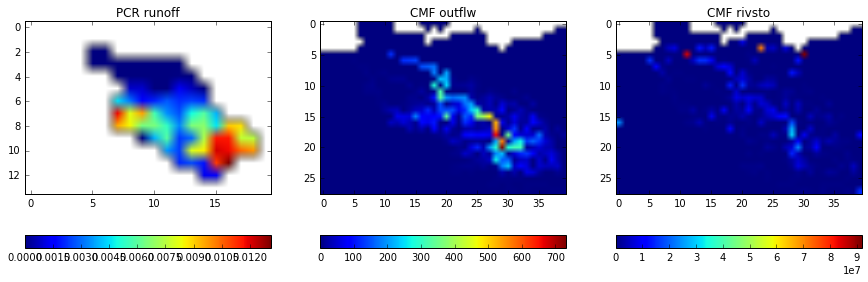

In [18]:
runoff = np.copy(PCR_bmi.get_var('landSurfaceRunoff'))
outflw = np.copy(CMF_bmi.get_var('outflw'))
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = np.copy(CMF_bmi.get_var('rivsto_out'))
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

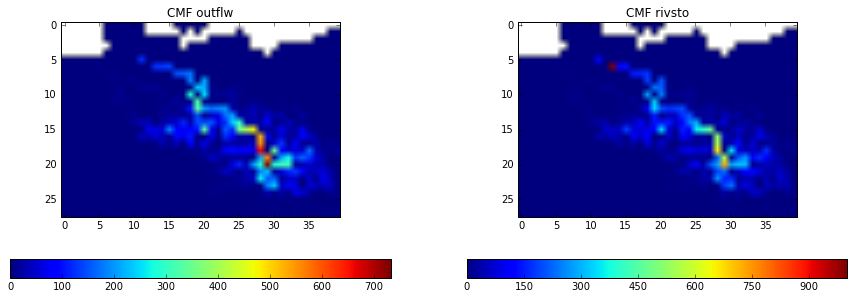

In [19]:
#- reassess location of CMF output point by comparing with simulated discharge
outflw = np.copy(CMF_bmi.get_var('outflw'))
outflw = np.ma.masked_greater(outflw, 1.e19)
test = np.copy(outflw)
test[6,13] = 1000

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(test)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [20]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

start time coupling:  2018-03-09 11:56:45.707581
end time coupling:  2018-03-09 12:59:58.502266
average time per update PCR->CMF->DFM:  0:00:03.463739


## Finalize models

In [21]:
PCR_bmi.finalize()
CMF_bmi.finalize()
DFM_bmi.finalize()


INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-09 13:00:00,029 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-09 13:00:00,031 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## Compare model results

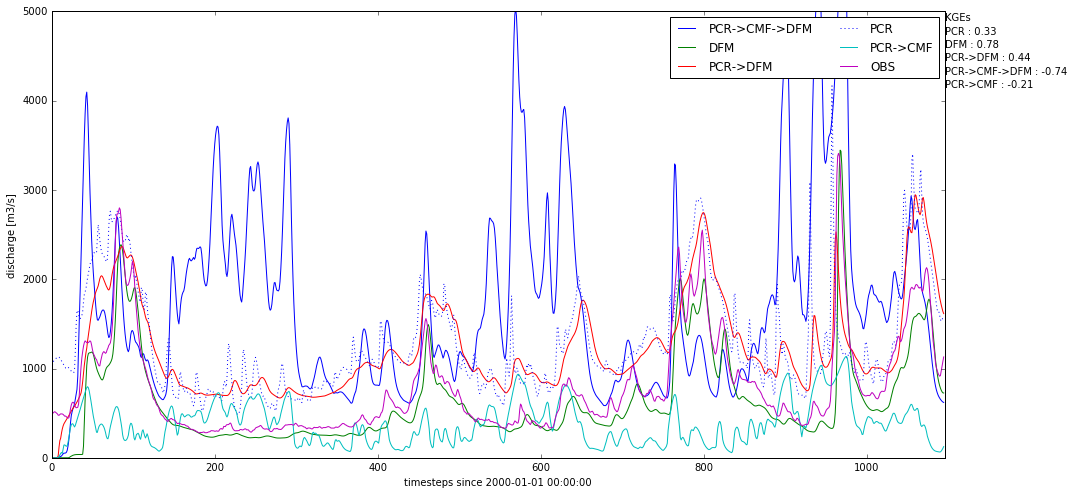

In [22]:
import matplotlib.dates as mdates
from netCDF4 import Dataset

#- load DFM output file (from this model run)
fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
#- laod DFM output file (from 1way coupled PCR->DFM run)
fo_1way = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_1way_his.nc')
#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- load PCR file
po = os.path.join(cwd, 'test_Elbe/', 'Qsim_Elbe_Darchau_30min_2000s_industrial_prefactored.dump')

#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- estract PCR data
pd = np.loadtxt(po, unpack=True, skiprows=4)
PCR_ND = pd[1]
PCR_ND = PCR_ND[:]

#- extrat CMF data
cd = np.loadtxt(cmf_outFile, unpack=True)

#- extract simulated discharge from nc-file (for this run)
no = Dataset(fo, 'r')
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])

#- extract simulated discharge from nc-file for 1way PCR->DFM
no_1way = Dataset(fo_1way, 'r')
qsim_1way = no_1way.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_1way = np.absolute(qsim_1way[:,2])
qsim_ND_1way = np.absolute(qsim_1way[:,0])
qsim_downBC_1way = np.absolute(qsim_1way[:,1])

#- extract simulated discharge from nc-file for DFM standalone
no_stA = Dataset(fo_stA, 'r')
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- limit to list with least entries
minLength = min(len(qobs_ND), len(qsim_ND), len(qsim_ND_1way), len(qsim_ND_stA), len(PCR_ND), len(cd))
if len(qobs_ND) > len(qsim_ND):
    qsim_ND = qsim_ND[:minLength]
    qobs_ND = qobs_ND[:minLength]
    PCR_ND = PCR_ND[:minLength]
    qsim_ND_1way = qsim_ND_1way[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    cd = cd[:minLength]

#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)
KGE_ND_1way = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_1way)
KGE_ND_1way = np.round(KGE_ND_1way,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)
KGE_ND_PCR = spotpy.objectivefunctions.kge(qobs_ND, PCR_ND)
KGE_ND_PCR = np.round(KGE_ND_PCR,2)
KGE_ND_CMF = spotpy.objectivefunctions.kge(qobs_ND, cd)
KGE_ND_CMF = np.round(KGE_ND_CMF,2)

#- plot
plt.figure(figsize=(16,8))
# plt.plot(qsim_downBC, ':', c='r', label = 'Qsim downBC')
plt.plot(qsim_ND, 'b', label = 'PCR->CMF->DFM')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qsim_ND_1way, 'r', label = 'PCR->DFM')
# plt.plot(qsim_downBC, ':',  c='k', label = 'Qsim downBC')
plt.plot(PCR_ND, ':',label = 'PCR')
plt.plot(cd, c='c', label = 'PCR->CMF')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(len(qsim_ND)+1,4900, 'KGEs') 
plt.text(len(qsim_ND)+1,4750, 'PCR : '+str(KGE_ND_PCR))
plt.text(len(qsim_ND)+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(len(qsim_ND)+1,4450, 'PCR->DFM : '+str(KGE_ND_1way))
plt.text(len(qsim_ND)+1,4300, 'PCR->CMF->DFM : '+str(KGE_ND))
plt.text(len(qsim_ND)+1,4150, 'PCR->CMF : '+str(KGE_ND_CMF))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(cwd, 'compareAndvalidate_Qsim_PCR2CMF2DFM.png'), dpi=300)

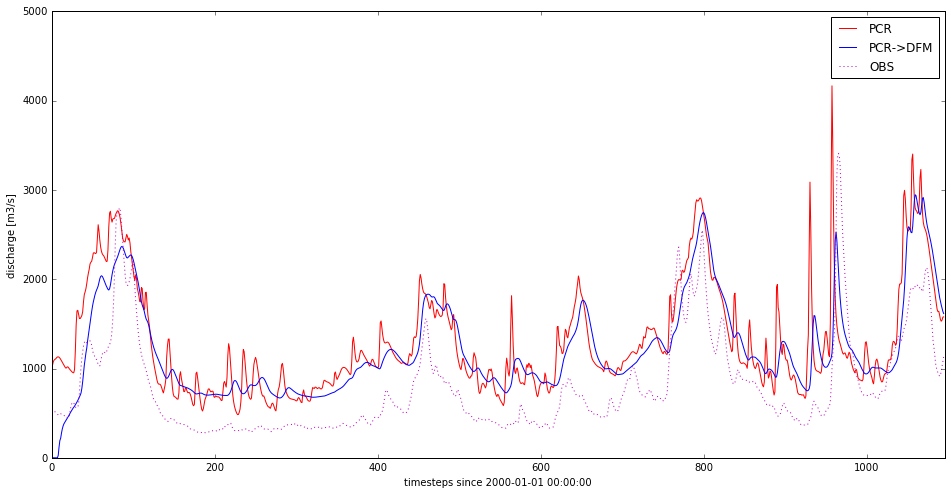

In [23]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(qsim_ND_1way, 'b', label = 'PCR->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

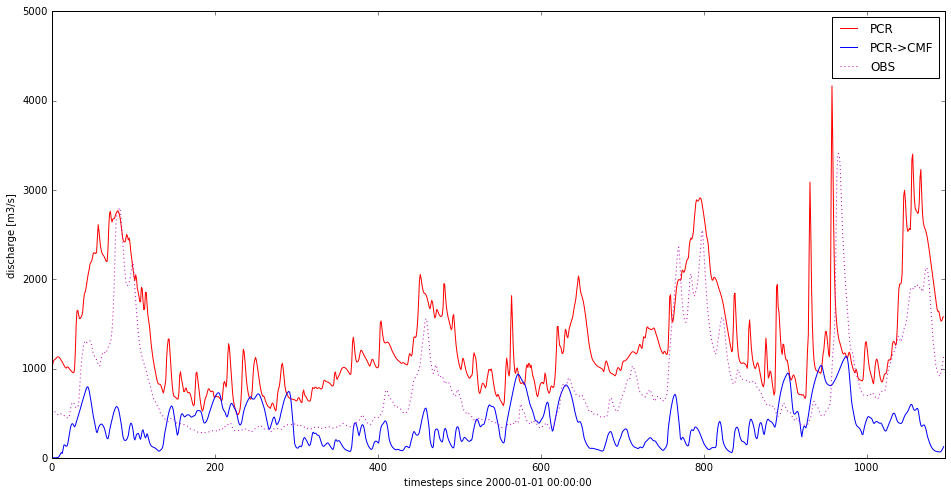

In [24]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(cd, 'b', label = 'PCR->CMF')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

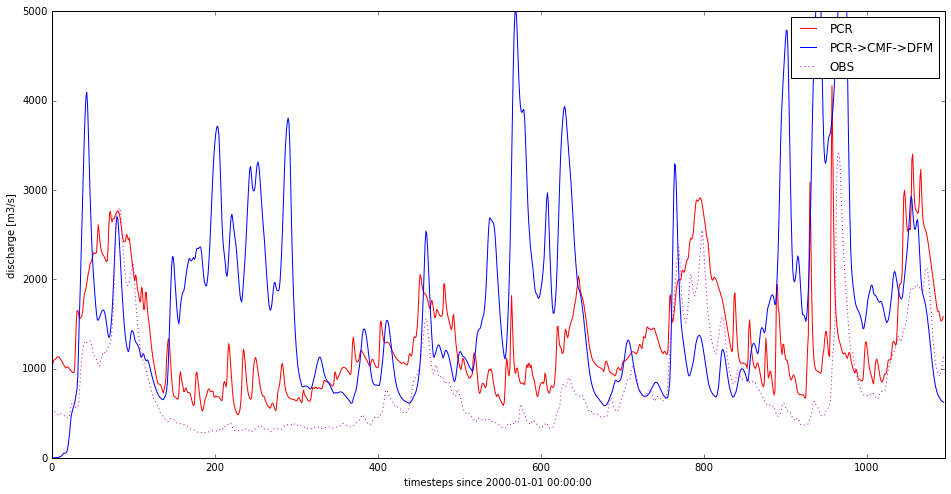

In [25]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(qsim_ND, 'b', label = 'PCR->CMF->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

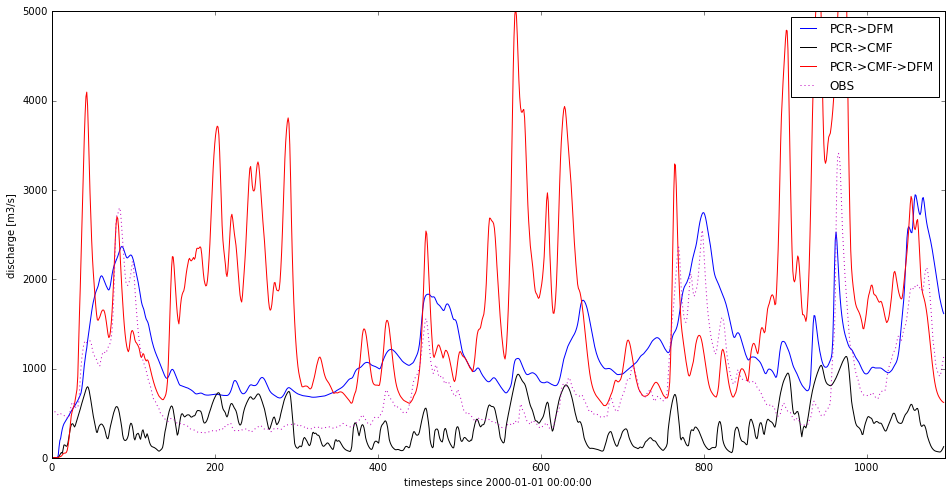

In [26]:
plt.figure(figsize=(16,8))
plt.plot(qsim_ND_1way, 'b', label = 'PCR->DFM')
plt.plot(cd, 'k', label = 'PCR->CMF')
plt.plot(qsim_ND, 'r', label = 'PCR->CMF->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))